# Making Business Decisions Based on Data - Course project

    by Isaac Nahmias
    Jan 2022

### Abstract

I am an analyst at a big online store. Together with the marketing department, I've compiled a list of hypotheses that may help boost revenue.\
In this paper I will prioritize these hypotheses, launch an A/B test, and analyze the results.

### Description of the data

#### Data used in the first part of the project

**`df1`** table from `hypotheses_us.csv`:

* `Hypotheses` — brief descriptions of the hypotheses
* `Reach` — user reach, on a scale of one to ten
* `Impact` — impact on users, on a scale of one to ten
* `Confidence` — confidence in the hypothesis, on a scale of one to ten
* `Effort` — the resources required to test a hypothesis, on a scale of one to ten. The higher the Effort value, the more resource-intensive the test.
    

#### Data used in the second part of the project

**`orders`** table from `orders_us.csv`:

* `transactionId` — order identifier
* `visitorId` — identifier of the user who placed the order
* `date` — of the order
* `revenue` — from the order
* `group` — the A/B test group that the user belongs to

**`visitors`** table from `visits_us.csv`:

* `date` — date
* `group` — A/B test group
* `visits` — the number of visits on the date specified in the A/B test group specified

### Importing libaries

In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [37]:
sns.set(style='darkgrid',palette='Dark2')

## Part I - Prioritizing Hypotheses

In [10]:
df1 = pd.read_csv('hypotheses_us.csv', sep=';')
df1.columns = df1.columns.str.lower().str.replace(' ', '_')
df1.head(10)

,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1
5,Add a customer review page. This will increase the number of orders,3,2,2,3
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5


### ICE framework to prioritize hypotheses

> $ICE = \frac{impact \times confidence}{effort} $

In [11]:
df1['ICE'] = (df21.impact * df21.confidence) / df21.effort

In [12]:
pd.options.display.max_colwidth = 150
df1[['hypothesis','ICE']].sort_values(by='ICE', ascending=False).head()

,hypothesis,ICE
8,Launch a promotion that gives users discounts on their birthdays,16.200000
0,Add two new channels for attracting traffic. This will bring 30% more users,13.333333
7,Add a subscription form to all the main pages. This will help you compile a mailing list,11.200000
6,Show banners with current offers and sales on the main page. This will boost conversion,8.000000
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,7.000000


### RICE framework to prioritize hypotheses

> $RICE = reach \times \frac{impact \times confidence}{effort} $

In [14]:
df1['RICE'] = df21.reach * df21.ICE

In [15]:
df1[['hypothesis','RICE']].sort_values(by='RICE', ascending=False).head()

,hypothesis,RICE
7,Add a subscription form to all the main pages. This will help you compile a mailing list,112.0
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,56.0
0,Add two new channels for attracting traffic. This will bring 30% more users,40.0
6,Show banners with current offers and sales on the main page. This will boost conversion,40.0
8,Launch a promotion that gives users discounts on their birthdays,16.2


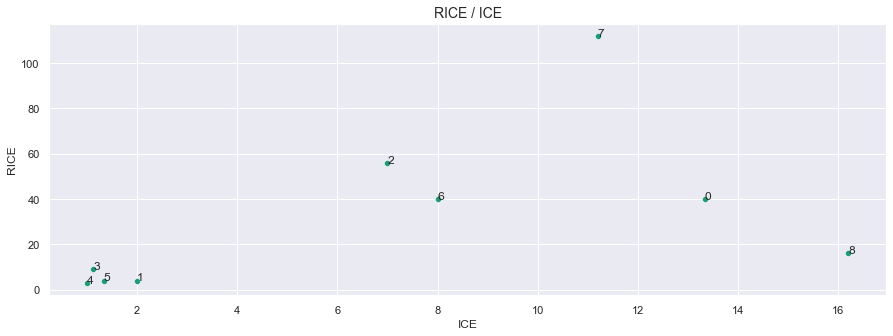

In [46]:
n = df1.index
plt.figure(figsize=(15,5))
ax = sns.scatterplot(x=df1['ICE'],y=df1['RICE'])
for i, txt in enumerate(n):
    ax.annotate(txt, (df1['ICE'][i], df1['RICE'][i]))
plt.title('RICE / ICE',fontdict={'fontsize':14})
plt.show()

### Section summery
Applying the ICE methood generates a score for every hypotheses in our list. The score is the ratio between the impact on the users and the costs of this testing. According to the ICE methood our number one priority is to test hypothesis #8: "Launch a promotion that gives users discounts on their birthdays".\
The RICE methood for prioritizing tasks is almost exactly like the ICE methood, but this time we are taking into account the number of users that will be affected by the update.\
For example, hypothesis #8 has dropped down from first place to 5th place because in terms of the number of users it is supposed to reach, its rating is only 1 in 10, and now our number one priority is to test hypothsis #7: "Add a subscription form to all the main pages. This will help you compile a mailing list", which was at third place before. hypothesis number 7 is the one with the highest cost-effectiveness ratio when considering the amount of users who are likely to be affected by the update.

I would recommand to start first with hypothesis number 7: *Add a subscription form to all the main pages. This will help you compile a mailing list*.

## Part II - A/B Test Analysis

**Uploading the data and preprocessing:**

In [47]:
visits = pd.read_csv('visits_us.csv')
visits['date'] = visits['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
print(visits.duplicated().sum(), 'duplicates.')
print(visits.isnull().sum().sum(), 'NaN.')
visits.head()

0 duplicates.
0 NaN.


,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [48]:
visits.describe(include='all').T

C:\Users\EB1B~1\AppData\Local\Temp/ipykernel_6292/2099587807.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  visits.describe(include='all').T


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
date,62,31,2019-08-01 00:00:00,2,2019-08-01,2019-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
group,62,2,A,31,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
visits,62.0,NaN,NaN,NaN,NaT,NaT,607.290323,114.40056,361.0,534.0,624.5,710.5,770.0


In [49]:
orders = pd.read_csv('orders_us.csv')
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
print(orders.duplicated().sum(), 'duplicates.')
print(orders.isnull().sum().sum(), 'NaN.')
orders.head()

0 duplicates.
0 NaN.


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


In [50]:
orders.describe(include='all').T

C:\Users\EB1B~1\AppData\Local\Temp/ipykernel_6292/2956559796.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  orders.describe(include='all').T


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
transactionId,1197.0,NaN,NaN,NaN,NaT,NaT,2155621385.529657,1229084904.760058,1062393.0,1166775572.0,2145193898.0,3237740112.0,4293855558.0
visitorId,1197.0,NaN,NaN,NaN,NaT,NaT,2165960143.099415,1236014192.14687,5114589.0,1111826046.0,2217984702.0,3177606451.0,4283872382.0
date,1197,31,2019-08-05 00:00:00,48,2019-08-01,2019-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
revenue,1197.0,NaN,NaN,NaN,NaT,NaT,131.491646,603.004729,5.0,20.8,50.2,130.4,19920.4
group,1197,2,B,640,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
groups_per_user = orders.groupby('visitorId')['group'].nunique().reset_index()
print('Number of users registered on both groups:',
      groups_per_user[groups_per_user['group']==2]['visitorId'].count())

Number of users registered on both groups: 58


In [52]:
orders = orders[~orders['visitorId'].isin(groups_per_user[groups_per_user['group']==2]['visitorId'])]

In [53]:
groups_per_user = orders.groupby('visitorId')['group'].nunique().reset_index()
print('Number of users registered on both groups:',
      groups_per_user[groups_per_user['group']==2]['visitorId'].count())

Number of users registered on both groups: 0


In [54]:
orders.groupby('group')['visitorId'].nunique()

group
A    445
B    528
Name: visitorId, dtype: int64

In [55]:
orders['revenue'].sort_values(ascending=False).head()

425     19920.4
1196     3120.1
1136     1425.8
744      1335.6
743      1050.0
Name: revenue, dtype: float64

In [56]:
orders = orders[orders['revenue'] < orders['revenue'].max()]
orders['revenue'].sort_values(ascending=False).head()

1196    3120.1
1136    1425.8
744     1335.6
743     1050.0
1103    1025.8
Name: revenue, dtype: float64

In [57]:
df2 = visits.merge(orders.groupby(['date','group']).agg(
    {'transactionId':'count','visitorId':'nunique','revenue':'sum'}).reset_index(),on=['date','group'])
df2.columns = ['date','group','visits','orders','buyers','revenue']
df2.head()

,date,group,visits,orders,buyers,revenue
0,2019-08-01,A,719,23,19,2266.6
1,2019-08-02,A,619,19,18,1468.3
2,2019-08-03,A,507,24,24,1815.2
3,2019-08-04,A,717,11,11,675.5
4,2019-08-05,A,756,22,22,1398.0


In [58]:
df2['group'] = df2['group'].astype('category')
df2['visits'] = pd.to_numeric(df2['visits'],downcast='integer')
df2['orders'] = pd.to_numeric(df2['orders'],downcast='integer')
df2['buyers'] = pd.to_numeric(df2['buyers'],downcast='integer')
df2['revenue'] = pd.to_numeric(df2['revenue'],downcast='float')
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 0 to 61
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     62 non-null     datetime64[ns]
 1   group    62 non-null     category      
 2   visits   62 non-null     int16         
 3   orders   62 non-null     int8          
 4   buyers   62 non-null     int8          
 5   revenue  62 non-null     float32       
dtypes: category(1), datetime64[ns](1), float32(1), int16(1), int8(2)
memory usage: 1.6 KB


**Summary:**

* The tables includes data on orders and visits made on August 2019.
* Both groups have the same amount of visits, but seems like users from group B made a bit more purchases than those in group A.
* 58 users have gotten into both group A and group B. For each of them I have replaced their group category according to the most common value, so if a user made 3 orders, 2 times as user from group A and one more time as from group B, from now on all his records are classified as group A only.
* We can already see from the description an outlier in the `revenue` column. I have removed one order with a revenue greater than 19K USD.
* There were 0 duplicates in the data and 0 nulls in both of the `visits` and `orders` tables.

I have joined the two tables into a new table called `df2`, and minimized its memory useage.

### The Cumulative revenue by group

In [59]:
groupA = df2[df2['group']=='A']
groupB = df2[df2['group']=='B']

In [60]:
groupA['cumul_rev'] = groupA['revenue'].cumsum()
groupA.head()

C:\Users\EB1B~1\AppData\Local\Temp/ipykernel_6292/2824230288.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  groupA['cumul_rev'] = groupA['revenue'].cumsum()


,date,group,visits,orders,buyers,revenue,cumul_rev
0,2019-08-01,A,719,23,19,2266.600098,2266.600098
1,2019-08-02,A,619,19,18,1468.300049,3734.900146
2,2019-08-03,A,507,24,24,1815.199951,5550.100098
3,2019-08-04,A,717,11,11,675.500000,6225.600098
4,2019-08-05,A,756,22,22,1398.000000,7623.600098


In [61]:
groupB['cumul_rev'] = groupB['revenue'].cumsum()
groupB.head()

C:\Users\EB1B~1\AppData\Local\Temp/ipykernel_6292/1013079916.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  groupB['cumul_rev'] = groupB['revenue'].cumsum()


,date,group,visits,orders,buyers,revenue,cumul_rev
31,2019-08-01,B,713,17,17,967.200012,967.200012
32,2019-08-02,B,581,23,22,2568.100098,3535.300049
33,2019-08-03,B,509,14,14,1071.599976,4606.899902
34,2019-08-04,B,770,14,13,1531.599976,6138.500000
35,2019-08-05,B,707,21,21,1449.300049,7587.799805


In [92]:
groupA.merge(groupB,how='outer')

,date,group,visits,orders,buyers,revenue,cumul_rev,cumul_ord,cumul_avch,conversion
0,2019-08-01,A,719,23,19,2266.600098,2266.600098,23,98.547830,0.031989
1,2019-08-02,A,619,19,18,1468.300049,3734.900146,42,88.926194,0.031390
2,2019-08-03,A,507,24,24,1815.199951,5550.100098,66,84.092426,0.035772
3,2019-08-04,A,717,11,11,675.500000,6225.600098,77,80.851949,0.030055
4,2019-08-05,A,756,22,22,1398.000000,7623.600098,99,77.006062,0.029837
...,...,...,...,...,...,...,...,...,...,...
57,2019-08-27,B,720,11,11,1746.900024,51964.601562,472,110.094495,0.028566
58,2019-08-28,B,654,22,22,1010.500000,52975.101562,494,107.237048,0.028759
59,2019-08-29,B,531,15,15,1681.199951,54656.300781,509,107.379766,0.028744
60,2019-08-30,B,490,21,21,3286.800049,57943.101562,530,109.326607,0.029124


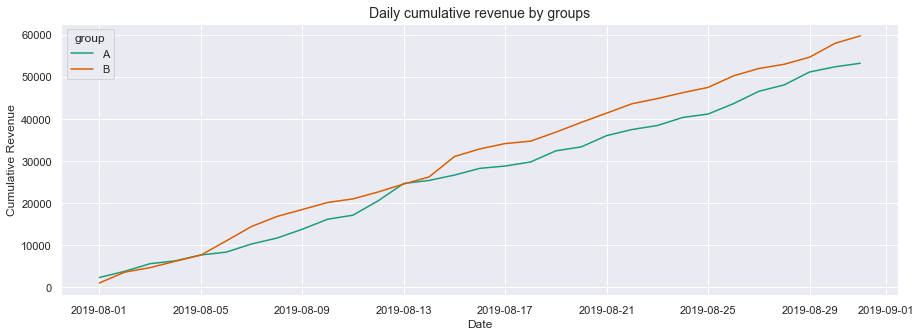

In [98]:
tdf = groupA.merge(groupB,how='outer')
plt.figure(figsize=(15,5))
sns.lineplot(x=tdf["date"], y=tdf["cumul_rev"], hue=tdf['group'])
plt.title('Daily cumulative revenue by groups',fontdict={'fontsize':14})
plt.ylabel('Cumulative Revenue')
plt.xlabel('Date')
plt.show()

**Conclusion:**

* The profits of both groups rise by a similar slope, indicating that their growth factor is almost the same, when group B's is a little bit higher.

### The cumulative average order size by group

In [63]:
groupA['cumul_ord'] =  groupA['orders'].cumsum()
groupA['cumul_avch'] = groupA['cumul_rev'] / groupA['cumul_ord']
groupA.head()

C:\Users\EB1B~1\AppData\Local\Temp/ipykernel_6292/434253065.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\EB1B~1\AppData\Local\Temp/ipykernel_6292/434253065.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,date,group,visits,orders,buyers,revenue,cumul_rev,cumul_ord,cumul_avch
0,2019-08-01,A,719,23,19,2266.600098,2266.600098,23,98.547830
1,2019-08-02,A,619,19,18,1468.300049,3734.900146,42,88.926194
2,2019-08-03,A,507,24,24,1815.199951,5550.100098,66,84.092426
3,2019-08-04,A,717,11,11,675.500000,6225.600098,77,80.851949
4,2019-08-05,A,756,22,22,1398.000000,7623.600098,99,77.006062


In [64]:
groupB['cumul_ord'] =  groupB['orders'].cumsum()
groupB['cumul_avch'] = groupB['cumul_rev'] / groupB['cumul_ord']
groupB.head()

C:\Users\EB1B~1\AppData\Local\Temp/ipykernel_6292/1662415525.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\EB1B~1\AppData\Local\Temp/ipykernel_6292/1662415525.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,date,group,visits,orders,buyers,revenue,cumul_rev,cumul_ord,cumul_avch
31,2019-08-01,B,713,17,17,967.200012,967.200012,17,56.894118
32,2019-08-02,B,581,23,22,2568.100098,3535.300049,40,88.382501
33,2019-08-03,B,509,14,14,1071.599976,4606.899902,54,85.312961
34,2019-08-04,B,770,14,13,1531.599976,6138.500000,68,90.272059
35,2019-08-05,B,707,21,21,1449.300049,7587.799805,89,85.256178


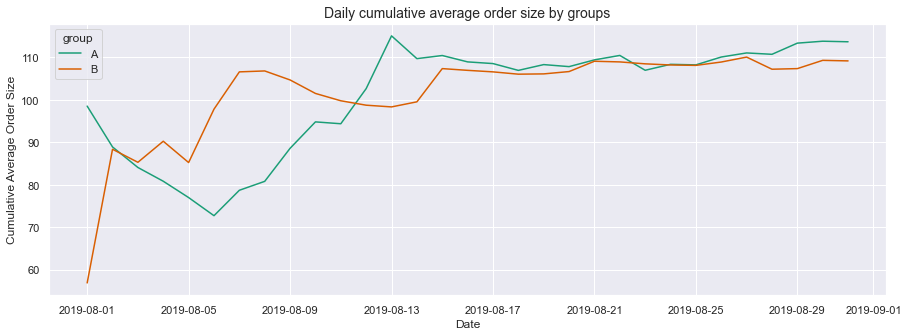

In [99]:
tdf = groupA.merge(groupB,how='outer')
plt.figure(figsize=(15,5))
sns.lineplot(x=tdf["date"], y=tdf["cumul_avch"], hue=tdf['group'])
plt.title('Daily cumulative average order size by groups',fontdict={'fontsize':14})
plt.ylabel('Cumulative Average Order Size')
plt.xlabel('Date')
plt.show()

**Conclusion:**

* At the beggining of the month we can see a big difference between the cumulative average order size of the two groups, but in second half we can see it stabilized.
* The most interesting thing about it is that both of the groups reached by the end of the month almost the same average: 110 USD per order. 

### The relative difference in cumulative average order size for group B compared with group A

In [66]:
rdca = groupA.merge(groupB,how='inner',on='date')
rdca['rel_diff'] = rdca['cumul_avch_y'] - rdca['cumul_avch_x']

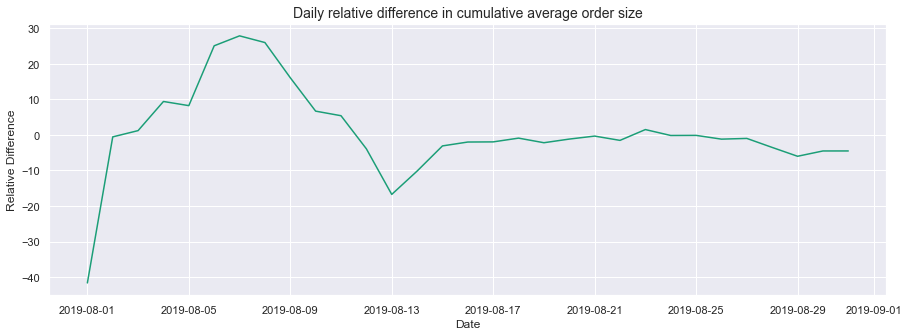

In [101]:
tdf = rdca
plt.figure(figsize=(15,5))
sns.lineplot(x=tdf["date"], y=tdf["rel_diff"])
plt.title('Daily relative difference in cumulative average order size',fontdict={'fontsize':14})
plt.ylabel('Relative Difference')
plt.xlabel('Date')
plt.show()

**Conclusion:**

* Again we can see a big difference between the cumulative average order size of the two groupsat the beggining of the month. 
* At several points the difference between the segments spikes. This means there must be some big orders and outliers.
* At the second half we can see the line revoloves around the 0 axis. The reason for that is logic, as we get closer to the end of the month, the more orders we add to the calculation, and the more orders we have the more closer we are to the real values.

### Each group's conversion rate as the ratio of orders to the number of visits for each day

In [68]:
groupA['conversion'] = groupA['orders'].cumsum() / groupA['visits'].cumsum()
groupB['conversion'] = groupB['orders'].cumsum() / groupB['visits'].cumsum()

C:\Users\EB1B~1\AppData\Local\Temp/ipykernel_6292/4188473220.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\EB1B~1\AppData\Local\Temp/ipykernel_6292/4188473220.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



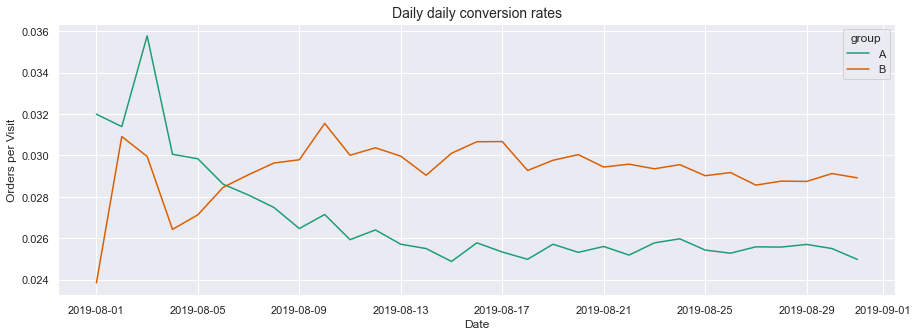

In [102]:
tdf = groupA.merge(groupB,how='outer')
plt.figure(figsize=(15,5))
sns.lineplot(x=tdf["date"], y=tdf["conversion"], hue=tdf['group'])
plt.title('Daily daily conversion rates',fontdict={'fontsize':14})
plt.ylabel('Orders per Visit')
plt.xlabel('Date')
plt.show()

In [70]:
print('Overall conversion, for group A:')
print(groupA['orders'].sum() / groupA['visits'].sum())

Overall conversion, for group A:
0.02497865072587532


In [71]:
print('Overall conversion, for group B:')
print(groupB['orders'].sum() / groupB['visits'].sum())

Overall conversion, for group B:
0.028917318672023684


**Conclusion:**

* Both of the daily and the overall conversion rate is very simmilar for the two groups, but group B's is higher.
* The overall convertion rate (orders per visits) is about 2.5% for both of the groups.

### The number of orders per user

In [72]:
visitors_orders = orders.groupby(['group','visitorId'])['transactionId'].count().reset_index()

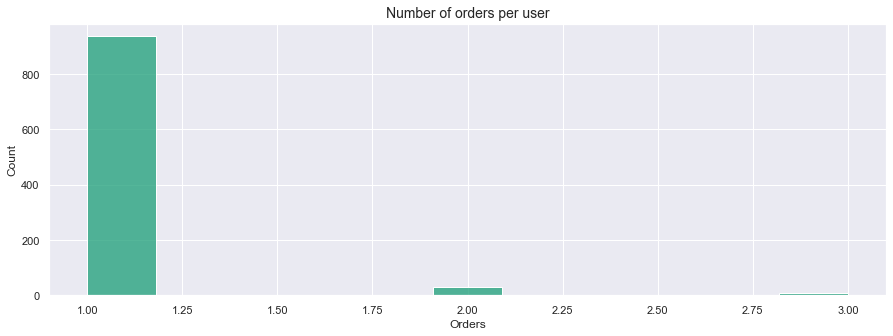

In [105]:
tdf = visitors_orders
plt.figure(figsize=(15,5))
sns.histplot(x=tdf["transactionId"])
plt.title('Number of orders per user',fontdict={'fontsize':14})
plt.ylabel('Count')
plt.xlabel('Orders')
plt.show()

In [75]:
for g in ['A','B']:
    print('Overall orders per user, for group',g,end=':\n')
    print(df2[df2['group']==g].orders.sum() / df2[df2['group']==g].buyers.sum())
    print('----')

Overall orders per user, for group A:
1.0240700218818382
----
Overall orders per user, for group B:
1.007366482504604
----


In [76]:
visitors_orders['transactionId'].value_counts() / visitors_orders['transactionId'].value_counts().sum()

1    0.962963
2    0.029835
3    0.007202
Name: transactionId, dtype: float64

In [77]:
percentile = np.percentile(visitors_orders['transactionId'], [95,99])
print('Not more than 5% of users placed more than {:.1f} orders.'.format(percentile[0]))
print('Not more than 1% of users placed more than {:.1f} orders.'.format(percentile[1]))

Not more than 5% of users placed more than 1.0 orders.
Not more than 1% of users placed more than 2.0 orders.


**Conclusion:**

* Over 96% of the users placed only 1 order, and only 0.7% of them placed the maximum number of 3 orders.
* Generally, the most extreme 1-5% of observed values are filtered out. Because of the low number of options in the number of orders I will declair 2 or more orders as an annomaly.

### Order prices

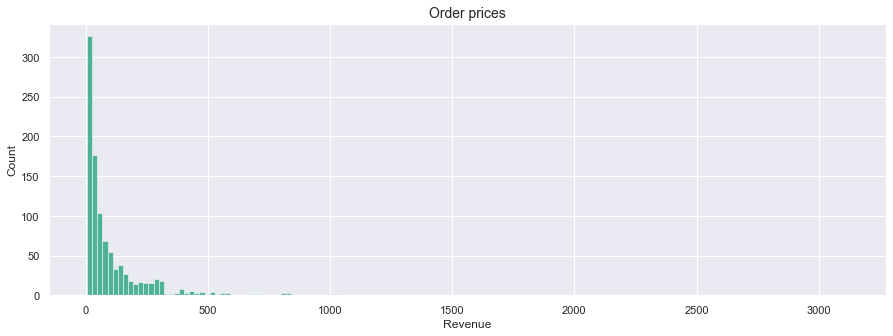

In [106]:
tdf = orders
plt.figure(figsize=(15,5))
sns.histplot(x=tdf["revenue"])
plt.title('Order prices',fontdict={'fontsize':14})
plt.ylabel('Count')
plt.xlabel('Revenue')
plt.show()

In [80]:
percentile = np.percentile(orders['revenue'], [95,99])
print('Not more than 5% of order prices are over {:.2f} USD'.format(percentile[0]))
print('Not more than 1% of order prices are over {:.2f} USD'.format(percentile[1]))

Not more than 5% of order prices are over 410.50 USD
Not more than 1% of order prices are over 828.27 USD


**Conclusion:**

* The majority of customers place orders up to 500 USD.
* No more than 5% of orders cost more than 410 USD, and no more than 1% cost more than 828 USD.
* In this case I will declair any order greater than 410 USD as an anomaly.

### The statistical significance of the difference in conversion between the groups, raw data

* **Null hypothesis**: There's no significant difference in conversion between the groups.
* **Hypothesis alternative**: There is a significant difference in conversion between the groups.

To test hypotheses, we use the Mann-Whitney method.

In [81]:
ordersByUsers_A = ( 
    orders[orders['group'] == 'A'].
    groupby('visitorId').
    agg({'transactionId':'nunique'})
)

ordersByUsers_B = ( 
    orders[orders['group'] == 'B'].
    groupby('visitorId').
    agg({'transactionId':'nunique'})
)

ordersByUsers_A = ordersByUsers_A.rename(columns = {'transactionId':'orders'})
ordersByUsers_B = ordersByUsers_B.rename(columns = {'transactionId':'orders'})

In [82]:
ordersByUsers_A.reset_index(inplace=True)
ordersByUsers_B.reset_index(inplace=True)

In [83]:
sampleA = (
    pd.concat([ordersByUsers_A['orders'],
               pd.Series(0, 
                         index = np.arange(visits[visits['group'] == 'A']
                                           ['visits']
                                           .sum() 
                                           -
                                           len(ordersByUsers_A['orders'])),
                         name = 'orders')],
              axis=0)
)
sampleB = (
    pd.concat([ordersByUsers_B['orders'],
               pd.Series(0, 
                         index = np.arange(visits[visits['group'] == 'B']
                                           ['visits']
                                           .sum() 
                                           -
                                           len(ordersByUsers_B['orders'])),
                         name = 'orders')],
              axis=0)
)

In [84]:
sampleA.head()

0    1
1    1
2    1
3    1
4    1
Name: orders, dtype: int64

In [85]:
print("p-value: {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.1%}".format(sampleB.mean()/sampleA.mean()-1))

p-value: 0.012
15.8%


Based on the raw data, there is a difference between groups A and B. The first row of the output gives us the p-value, 0.006, which is lower than 0.05. So we reject the null hypothesis that there's not a statistically significant difference in conversion between the groups. The relative gain of group B is 15.8%

### The statistical significance of the difference in average order size between the groups, raw data

* **Null hypothesis:** The average order size is the same in both groups.
* **Hypothesis alternative:** The average order size is different in both groups.

In [86]:
print('p-value: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'],
                                          orders[orders['group']=='B']['revenue'])[1]))
print('{0:.1%}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value: 0.823
-4.0%


The p-value is considerably higher than 0.05, so there's no reason to reject the null hypothesis and conclude that average order size differs between the groups. Nonetheless, the average order size for group B is much smaller than it is for group A.

### The statistical significance of the difference in conversion between the groups, filtered data

In [87]:
orders_low_limit = np.percentile(visitors_orders['transactionId'], 95)
revenue_low_limit = np.percentile(orders['revenue'], 95)

usersWithManyOrders = pd.concat(
    [ordersByUsers_A[ordersByUsers_A['orders'] > orders_low_limit]['visitorId'],
     ordersByUsers_B[ordersByUsers_B['orders'] > orders_low_limit]['visitorId']], axis = 0)

usersWithExpensiveOrders = orders[orders['revenue'] > revenue_low_limit]['visitorId']

abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()

print('We have {:} anomalous users in total.'.format(len(abnormalUsers)))

We have 85 anomalous users in total.


In [88]:
sampleAFiltered = pd.concat(
    [ordersByUsers_A[np.logical_not(ordersByUsers_A['visitorId'].isin(abnormalUsers))]['orders'],
     pd.Series(0, index=np.arange(visits[visits['group']=='A']['visits'].sum() - len(ordersByUsers_A['orders'])),
               name='orders')],axis=0)

sampleBFiltered = pd.concat(
    [ordersByUsers_B[np.logical_not(ordersByUsers_B['visitorId'].isin(abnormalUsers))]['orders'],
     pd.Series(0, index=np.arange(visits[visits['group']=='B']['visits'].sum() - len(ordersByUsers_B['orders'])),
               name='orders')],axis=0)

In [89]:
print("p-value: {0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))

print("{0:.1%}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value: 0.016
17.4%


According to the filtered data, the conversion by groups also differed statistically significantly. The ratio of the mean values practically did not change. It turns out that "anomalous" users had weak effect on the value of this metric.

### The statistical significance of the difference in conversion between the groups, filtered data

In [90]:
print('p-value: {0:.3f}'.format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))

print('{0:.1%}'.format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1))

p-value: 0.771
-3.3%


Again, there's no reason to reject the null hypothesis and conclude that average order size differs between the groups.
On the filtered data, the average order size for group B is the same as for group A. We can conclude that the anomalous values greatly influenced the result obtained earlier. Without abnormal values, the average order value does not change.

**Conclusions on A / B testing:**
* there are statistically significant differences in conversion between groups A and B (both in raw data and in purified data)
* there are no statistically significant differences in the average check between groups A and B (both for raw data and for purified data).

### Make a decision based on the test results

>As a result of the data obtained, I can advise to stop testing. The test result can be considered positive. We determined that the data in the groups are statistically different, and the result in group B is about 16% better. As for the average check, it has not changed between groups A and B. This tells us that our change will improve conversions and keep the average order value at the same level.

## Conclusions

I analyzed the behavior of the visitors in the online store in August 2019. The visitors were divided into two groups, A and B, and I found that:
1. The visitors from group B brought more profits (almost 20K USD) to the store than from group A. Maybe because they make more orders and maybe because the orders they place are more expensive.
1. At the cumulative average level the visitors from Group B are leading, they tend to pay a little more for each order (A = 113.8 USD per order, B = 115.8 USD per order).
1. When I checked the conversion rates, I found that again Group B leads. The average conversion rate for group B is 3.58% when for group A is 2.76%.
1. When I checked the total orders in relation to the total number of users, I found that the average is almost the same for both groups (1.04).

My next task was to test whether my findings were statistically significant. I found that the average profit per order is not significant and nothing significant can be deduced from it, but what did turn out to be significantly different is the conversion rate of the visitors.

The test result can be considered positive. Based on the test results, it was found that the conversion rate will increase when changes are made, and the average price will remain the same.